In [144]:
!apt-get install graphviz
!pip install graphviz


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
graphviz is already the newest version (2.42.2-6ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.


Imports

In [145]:
from graphviz import Digraph
from graphviz import Source
from IPython.display import Image,display,clear_output
import csv
import time
import re

In [146]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Movie class

In [147]:
class Movie:
  def __init__(self,title,WE,DE,DPE,FE,FPE,year):
    #Title
    self.title=title
    #Worldwide Earnings
    self.WE=WE
    #Domestic Earnings
    self.DE=DE
    #Domestic Percent Earnings
    self.DPE=DPE
    #Foreign Earnings
    self.FE=FE
    #Foreign Percent Earnings
    self.FPE=FPE
    #Year
    self.year=year


Family Class

In [148]:
class Family:
  def __init__(self):
    #Representacion de la familia de un nodo en el arbol
    self.parent=None
    self.unc=None
    self.grandpa=None

Tree Classes

In [149]:
from pickle import NONE
class Tree:
    def __init__(self):
        self.root = None

    def insert(self,data):
      if(self.root is None):
        #Si no hay raiz(No hay nodos en el arbol) entonces asignamos al nuevo nodo como raiz
        self.root=Node(data)
      else:
        #A la raiz se le asigna lo que devuelva la funcion por si la raiz del arbol cambia por alguna rotacion
        self.root=self.root.insert(data)

    def lookup(self,data):
      if(self.root is not None):
        #Dado un titulo, se busca un nodo
        return self.root.lookup(data)
      return None

    def delete(self, data):
      #Dado un titulo, se elimina el nodo
        if self.root is not None:
            self.root = self.root.delete(data)


    def find_movies(self, year, foreign_earnings_min):
        # Función que busca varios nodos en base a unos parametros(year,foreign_earnings_min)
        results = []
        if self.root is not None:
            self.root.find_movies(year, foreign_earnings_min, results)
        return results

    def to_dot(self):
      #Genera un dot del arbol
        dot = Digraph()
        if self.root is not None:
            self.root.to_dot(dot)
        return dot

    def showInfo(self,node):
      #Mostrar informacion de un nodo(balanceo,nivel,padre,abuelo,tio)
        self.root.showInfo(node)

    def recorridoNiveles(self):
      #Empezar el recorrido por niveles de manera recursiva
      q=[]
      if self.root is not None:
        q= self.root.recorridoNiveles(q)
      return q

class Node:
    def __init__(self, data):
        self.data = data
        self.left = None
        self.right = None
        self.balance= 0


    def insert (self, data):
      if(data.title==self.data.title):
        #Si ya existe la informacion en el arbol entonces se termina el llamado recursivo y se devuelve el nodo original
        print("Esta pelicula ya existe en el arbol")
        return self

      #Recorrido izquierdo
      if(data.title<self.data.title):
        if(self.left is None):
          #Cuando se encuentra en donde agregar el nuevo nodo
          self.left = Node(data)

        else:
          #Se continua el recorrido y se le asigna lo que sea que retorne la funcion al terminar la recursividad
          self.left=self.left.insert(data)

      #Recorrido derecho
      if(data.title>self.data.title):
        if(self.right is None):
          #Cuando se encuentra en donde agregar el nuevo nodo
          self.right=Node(data)

        else:
          #Se continua el recorrido y se le asigna lo que sea que retorne la funcion al terminar la recursividad
          self.right=self.right.insert(data)
      #encontrar los factores de balanceo de los nodos recorridos
      self.find_balance()
      #Logica de rotaciones, si es necesaria se devuelve la nueva raiz del subarbol
      if(self.right):
        if (self.balance==2 and self.right.balance == 1):
          return self.left_rotation()
        elif (self.balance==2 and self.right.balance == -1):
          return self.double_right_left_rotation()

      if self.left:
        if (self.balance== -2 and self.left.balance== -1):
          return self.right_rotation()
        elif(self.balance==-2 and self.left.balance==1):
         return self.double_left_right_rotation()
      #Si no se requieren rotaciones la raiz del subarbol permanece igual
      return self


    def lookup(self,data):
      #Si se encontro la informacion, devuelve el nodo
      if (data==self.data.title):
        return self
      #Si el dato a buscar es menor que el actual, se continua el recorrido por la izquierda
      if(data<self.data.title and self.left is not None):
        return self.left.lookup(data)
      #Si el dato a buscares mayor que el actual, se continua el recorrido por la derecha
      if(data>self.data.title and self.right is not None):
        return self.right.lookup(data)
      #Si no se encontro la informacion, entonces retorna None
      return None

    def find_height(self):
      izq=0
      der=0
      #Si existe un subarbol izquierdo se continua la recursivad en ese nodo
      if (self.left is not None):
        #Suma de los recorridos izquierdos
        izq=self.left.find_height()
      #Si existe un subarbol derecho se continua la recursivad en ese nodo
      if(self.right is not None):
        #Suma de los recorridos derechos
        der=self.right.find_height()
      #Devuelve el subarbol de mayor altura y se le suma un 1 a esa altura
      return max(izq,der)+1

    def find_balance(self):
      if (self.right is not None):
        #Si existe un subarbol derecho entonces se encuentra su la altura
        right=self.right.find_height()
      else:
        #Si no existe un subarbol derecho entonces la altura derecha es 0
        right=0

      if (self.left is not None):
        #Si existe un subarbol izquierdo entonces se encuentra su la altura
        left=self.left.find_height()
      else:
        #Si no existe un subarbol izquierdo entonces la altura izquierda es 0
        left=0
      #Con las dos alturas obtenidas se calcula el factor de balanceo
      self.balance=right-left

    def delete(self, data):
      if data < self.data.title:
          if self.left is not None:
              self.left = self.left.delete(data)
      elif data > self.data.title:
          if self.right is not None:
              self.right = self.right.delete(data)
      else:
          # Caso 1: El nodo a eliminar es una hoja
          if self.left is None and self.right is None:
              return None
          # Caso 2: El nodo a eliminar tiene un solo hijo
          if self.left is None:
              return self.right
          if self.right is None:
              return self.left
          # Caso 3: El nodo a eliminar tiene dos hijos (usando el predecesor in-order)
          max_smaller_node = self.left.get_max()  # Busca el predecesor in-order
          self.data = max_smaller_node.data
          self.left = self.left.delete(max_smaller_node.data.title)

      self.find_balance()
      return self.rebalance()

    def get_max(self):
      #Buscando el mayor del subarbol izquierdo (self)
      if self.right is None:
          return self
      else:
          return self.right.get_max()

    def rebalance(self):
      # Rotaciones para mantener el balance
      if self.balance > 1:
          if self.right and self.right.balance < 0:
              self.right = self.right.right_rotation()
          return self.left_rotation()
      if self.balance < -1:
          if self.left and self.left.balance > 0:
              self.left = self.left.left_rotation()
          return self.right_rotation()
      return self

    #Todos los tipos de rotaciones
    def double_left_right_rotation(self):
      if self.left:
        self.left=self.left.left_rotation()
      return self.right_rotation()

    def double_right_left_rotation(self):
      if self.right:
        self.right=self.right.right_rotation()
      return self.left_rotation()

    def right_rotation(self):
      aux=self.left
      self.left=aux.right
      aux.right=self
      self.find_balance()
      aux.find_balance()
      return aux

    def left_rotation(self):
      aux=self.right
      self.right=aux.left
      aux.left=self
      self.find_balance()
      aux.find_balance()
      return aux

    def findLevel(self,node,level=0):
      if self.data.title==node.data.title:
        #Se encontro el nodo entonces se devuelve la suma de los niveles hasta este punto
        return level
      #Se continua el recorrido con respecto a la metrica y si existe un subarbol para donde ir
      if self.left and node.data.title<self.data.title:
        #Se devuelve el recorrido izquierdo, se le suma un 1 al nivel para indicar que esta avanzando mas abajo en el arbol
        return self.left.findLevel(node,level+1)
      #Se continua el recorrido con respecto a la metrica y si existe un subarbol para donde ir
      if self.right and node.data.title>self.data.title:
        #Se devuelve el recorrido izquierdo, se le suma un 1 al nivel para indicar que esta avanzando mas abajo en el arbol
        return self.right.findLevel(node,level+1)
      #El nodo no se encontro
      return -1

    def recorridoNiveles(self,q,lvl=0):
      #Si la longitud del vector q es menor o igual que el actual
      if len(q)<=lvl:
        #Se le agrega una nueva lista para poder almacenar los nodos del nuevo nivel
        q.append([])
      #Se agrega el nodo actual a la lista del nivel actual
      q[lvl].append(self.data.title)

      if(self.left is not None):
        #Se continua al nodo izquierdo, y se le suma 1 al lvl para indicar que se aumento de nivel
        self.left.recorridoNiveles(q,lvl+1)
      if(self.right is not None):
        #Se continua al nodo derecho, y se le suma 1 al lvl para indicar que se aumento de nivel
        self.right.recorridoNiveles(q,lvl+1)
      #No se puede recorrer mas el arbol y se devuelven los niveles y nodos hasta este punto
      return q

    def showInfo(self,node):
      fam=Family()
      fam.parent=None
      fam.unc=None
      fam.grandpa=None
      #Mostrar el nivel de un nodo, se llama a la funcion y devuelve un entero
      print("El nivel del nodo es: "+str(self.findLevel(node)))
      #Mostrar el factor de balanceo, se obtiene del atributo del mismo nodo
      print("El factor de balanceo del nodo es:"+str(node.balance))
      #Se buscan los familiares del nodo
      fam=self.findFam(node,fam)

      if fam.parent:
        #Si tiene padre se muestra
        print("El padre del nodo es: "+fam.parent.data.title)
        if fam.grandpa:
          #Si tiene abuelo tambien se muestra
          print("El abuelo del nodo es: "+fam.grandpa.data.title)
          if fam.unc:
            #Si tiene tio tambien se muestra
            print("El tio del nodo es: "+fam.unc.data.title)
          else:
            #No tiene tio
            print("El nodo no tiene tio")
        else:
          #No tiene abuelo(No puede tener tio)
          print("El nodo no tiene ni abuelo ni tio")
      else:
        #No tiene padre(No puede tener abuelo ni tio)
        print("El nodo no tiene padre ni abuelo ni tio")

    def findFam(self,node,fam=Family()):
      if self.left:
        if self.left.left and self.left:
          #Si el nodo actual tiene un hijo izquierdo y un nieto que tiene la info que estamos buscando
          if(self.left.left.data.title==node.data.title):
            #El nodo actual seria el abuelo
            fam.grandpa=self
            #El hijo izquierdo seria el padre
            fam.parent=self.left
            if self.right:
              #En caso de que el abuelo tenga un hijo derecho, entonces ese seria el tio
              fam.unc=self.right
        if self.left and self.left.right:
          #Si el nodo actual tiene un hijo izquierdo y un nieto que tiene la info que estamos buscando
          if (self.left.right.data.title==node.data):
            #El nodo actual seria el abuelo
            fam.grandpa=self
            #El hijo izquierdo seria el padre
            fam.parent=self.left
            if self.right:
              #En caso de que el abuelo tenga un hijo derecho, entonces ese seria el tio
              fam.unc=self.right

        #No puede haber abuelo entonces se busca el padre
        if self.left.data.title==node.data.title:
          #Si tiene hijo izquierdo y es el nodo que estamos buscando entonces el nodo actual seria el padre
          fam.parent=self
        else:
          #Si tiene hijo izquierdo pero no es el que estamos buscando entonces se continua la busqueda desde el hijo izquierdo
          self.left.findFam(node,fam)

      if self.right:
        if self.right and self.right.right:
          #Si el nodo actual tiene un hijo derecho y un nieto que tiene la info que estamos buscando
          if(self.right.right.data.title==node.data.title):
            #El nodo actual seria el abuelo
            fam.grandpa=self
            #El hijo derecho seria el padre
            fam.parent=self.right
            if self.left:
              #En caso de que el abuelo tenga un hijo derecho, entonces ese seria el tio
              fam.unc=self.left

        if self.right and self.right.left:
          #Si el nodo actual tiene un hijo derecho y un nieto que tiene la info que estamos buscando
          if(self.right.left.data.title==node.data.title):
            #El nodo actual seria el abuelo
            fam.grandpa=self
            #El hijo derecho seria el padre
            fam.parent=self.right
            if self.left:
              #En caso de que el abuelo tenga un hijo derecho, entonces ese seria el tio
              fam.unc=self.left

        #No puedo haber abuelo entonces se busca el padre
        if self.right.data.title==node.data.title:
          #Si tiene hijo derecho y es el nodo que estamos buscando entonces el nodo actual seria el padre
          fam.parent=self
        else:
          #Si tiene hijo derecho pero no es el que estamos buscando entonces se continua la busqueda desde el hijo izquierdo
          self.right.findFam(node,fam)

      #No se puede recorrer mas el arbol entonces se devuelva la familia que se encontro
      return fam


    def to_dot(self, dot, parent=None):
      #Generar dot del arbol
      if parent is not None:
        dot.edge(sanitize_label(parent.data.title), sanitize_label(self.data.title))
      if self.left:
        self.left.to_dot(dot, self)
      if self.right:
        self.right.to_dot(dot, self)



    def find_movies(self, year, foreign_earnings_min, results):
        # Verificamos el nodo actual si cumple con los criterios
        if self.data.year == year and \
           self.data.DPE < self.data.FPE and \
           self.data.FE >= foreign_earnings_min:
            results.append(self.data)
      # Recursivamente buscamos en el subárbol izquierdo y derecho
        if self.left:
            self.left.find_movies(year, foreign_earnings_min, results)
        if self.right:
            self.right.find_movies(year, foreign_earnings_min, results)
        return results





def load_movies_from_csv(file_path,limit=None):
    movies = []
    with open(file_path, newline='', encoding='utf-8') as csvfile:
        reader = csv.DictReader(csvfile)
        count = 0
        for row in reader:
            #Si el contador(cuantas veces a agregado una pelicula a la lista) entonces se termina el ciclo for
            if limit is  None or count >= limit:
                break
            #Obtener los valores de la fila y asignarlos a unas variables
            title = row["Title"]
            WE = int(row["Worldwide Earnings"])
            year = int(row['Year'])
            DE = int(row["Domestic Earnings"])
            DPE = float(row['Domestic Percent Earnings'])
            FPE = float(row['Foreign Percent Earnings'])
            FE = int(row['Foreign Earnings'])
            #Con las variables obtenidas crear un objeto Movie
            movie = Movie(title, WE, DE, DPE, FE, FPE, year)
            #Ese objeto movie agregarselo a la lista de peliculas
            movies.append(movie)
            #Despues de agregar una pelicula a la lista, incrementar el contador
            count += 1
    #Retornar lista de peliculas
    return movies

def insertarTitulos(file_path,titulos):
    movies = []
    with open(file_path, newline='', encoding='utf-8') as csvfile:
        reader = csv.DictReader(csvfile)


        rows = list(reader)

        for nombre in titulos:
            for row in rows:
                if row["Title"] == nombre:
                        title = row["Title"]
                        WE = int(row["Worldwide Earnings"])
                        year = int(row['Year'])
                        DE = int(row["Domestic Earnings"])
                        DPE = float(row['Domestic Percent Earnings'])
                        FPE = float(row['Foreign Percent Earnings'])
                        FE = int(row['Foreign Earnings'])

                        movie = Movie(title, WE, DE, DPE, FE, FPE, year)
                        movies.append(movie)



    #Retornar lista de peliculas
    return movies

def cargaTXT(file_path):

    vector = []

    pattern = re.compile(r'"(.*?)"|(\S+)')

    try:
        with open(file_path, 'r') as file:
            for line in file:

                line = line.strip()


                if not line:
                    continue


                matches = pattern.findall(line)


                for match in matches:

                    value = match[0] or match[1]
                    vector.append(value)

    except FileNotFoundError:
        print(f"Error: The file at {file_path} was not found.")
    except IOError:
        print(f"Error: An IOError occurred while reading the file at {file_path}.")

    return vector



def sanitize_label(label):
    #Limpiar los titulos para evitar errores de sintaxis al utilizar graphviz
    if label is None:
        return '""'  # Si no hay "label" entonces se devuelve un string cualquiera vacio, para evitar errores

    #Eliminando simbolos posiblemente problematicos
    sanitized = label.replace('\\', '')
    sanitized = sanitized.replace('"', '')
    sanitized = sanitized.replace('\n', '')
    sanitized = sanitized.replace('~', '')
    sanitized = sanitized.replace('!', '')
    sanitized = sanitized.replace('?', '')
    sanitized = sanitized.replace('|', '')
    sanitized = sanitized.replace('<', '')
    sanitized = sanitized.replace('>', '')
    sanitized = sanitized.replace('/', '')
    sanitized = sanitized.replace('@', '')
    sanitized = sanitized.replace(':', '')
    sanitized = sanitized.replace('.', '')
    sanitized = sanitized.replace('-', '')

    # Diccionaria para reemplazar caracteres o eliminar caracteres problematicos
    caracteres = {
        'ç': 'c', 'é': 'e', 'ó': 'o', '³': '',
        '×': 'x', 'á': 'a', 'ä': 'a', '·': '',
        'ê': 'e', 'Æ': '', 'É': 'E', 'ö': 'o',
        'ñ': 'n', 'ò': 'o', 'í': 'i', 'û': 'u',
        'è': 'e', 'ü': 'u', 'ô': 'o', '¡': 'i',
        'å': 'a'
    }
    #Reemplazar o eliminar utilizando el diccionario
    for char, replacement in caracteres.items():
        sanitized = sanitized.replace(char, replacement)
    #Retornar el titulo con sintaxis adecuado para generar la imagen del arbol
    return f'"{sanitized}"'

def render_and_display(tree):
  #Se obtiene el dot del arbol
  dot=tree.to_dot()
  #Con el dot del arbol se crea la imagen
  dot.render('tree_after_insertion', format='png', cleanup=True)
  #Se muestra la imagen
  display(Image('tree_after_insertion.png'))


def read_int(txt, min=None, max=None):
  #Validacion de input, se obtiene el input, el limite inferior(si lo hay) y el limite superior(si lo hay)
    while True:
        try:
            value = int(input(txt))
            while((min is not None and value < min) or (max is not None and value > max)):
                value=int(input("Ingrese un valor entre "+str(min)+" y "+str(max)))

            return value
        except ValueError:
          #No se ingreso un int
            print("Ingrese un numero")







Main

Digite el nombre de la pelicula que desea eliminarThe Boss Baby
Nodo eliminado


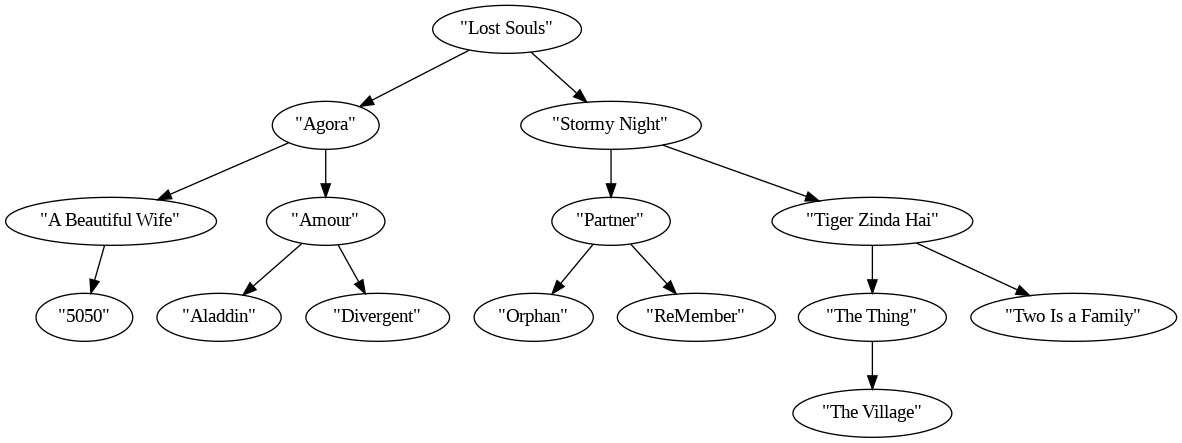

-----------------------------------------------------------------
--------------------------Bienvenid@-------------------------------
1.Generar Arbol con csv
2.Insertar Pelicula Nueva
3.Eliminar Nodo
4.Buscar informacion de nodos
5.Mostrar Recorrido por niveles
6.Vaciar Arbol
7.Buscar las peliculas del txt
0.SALIR
-----------------------------------------------------------------


In [ ]:
opt=1#Entrar en el ciclo del meno
tree=Tree()
listaTXT=cargaTXT("/content/drive/MyDrive/test_movies.txt")
peliculas=insertarTitulos("/content/drive/MyDrive/dataset_movies.csv",listaTXT)
while(opt != 0):

  print("--------------------------Bienvenid@-------------------------------")
  print("1.Generar Arbol con csv")
  print("2.Insertar Pelicula Nueva")
  print("3.Eliminar Nodo")
  print("4.Buscar informacion de nodos")
  print("5.Mostrar Recorrido por niveles")
  print("6.Vaciar Arbol")
  print("7.Buscar las peliculas del txt")
  print("0.SALIR")
  print("-----------------------------------------------------------------")
  time.sleep(5)#Sin esto no salia la caja de input despues de mostrar la imagen del arbol
  if(opt!=0):#Sin esto no salia la caja de input despues de mostrar la imagen del arbol
    #Leer la opcion ingresada
    opt = read_int("Digite una opcion: ",0,7)
  if(opt == 1):
    #Opicon 1
    clear_output(wait=True)
    num=read_int("Cuantas filas se deberian leer(Numero total de filas:4953)? ",1,4953)#Limite de filas a leer
    movies = load_movies_from_csv("/content/drive/MyDrive/dataset_movies.csv",num)#Lectura de las primeras num entradas
    for movie in movies:
      tree.insert(movie)#Insertar todas las peliculas leidas del archivo
    print("Arbol generado!")
    #Reestablecer opcion
    opt=1
  if(opt == 2):
    clear_output(wait=True)
    #Obtener input del usuario acerca de la pelicula a ingresar
    titulo=input("Digite el titulo de la pelicula")
    ingresos_mundiales=read_int("Digite los ingresos mundiales",0)
    ingresos_dom=read_int("Digite los ingresos domesticos",0)
    por_ingresos_dom=read_int("Digite el porcentaje de ingresos que fueron domesticos",0,100)
    ingresos_extranjeros=read_int("Digite los ingresos extranjero ",0)
    por_ingresos_ext=read_int("Digite el porcentaje de ingresos que fueron del extranjero",0,100)
    fecha=read_int("Digite el año en el que salio la pelicula",1895,2024)
    #Con la informacion ingresada insertar la pelicula nueva
    tree.insert(Movie(titulo,ingresos_mundiales,ingresos_dom,por_ingresos_dom,ingresos_extranjeros,por_ingresos_ext,fecha))
  if(opt == 3):
    clear_output(wait=True)
    #Obtener nombre de pelicula a eliminar
    name=input("Digite el nombre de la pelicula que desea eliminar")
    #Buscar si existe esa pelicula en el arbol
    node=tree.lookup(name)

    if(node is not None):
      tree.delete(node.data.title)#Existe, se elimina
      print("Nodo eliminado")
    else:
      print("La pelicula no existe en el arbol")#No existe, no se puede eliminar

  if(opt == 4):
    node=None
    print("1. Un nodo en especifico")
    print("2. Busqueda especial de nodos")
    #Leer el tipo de busqueda deseado
    opt=read_int("Digite una opcion",1,2)
    if opt == 1:
      name=input("Digite el nombre de la pelicula")#Leer titulo de la pelicula que se buscara
      node=tree.lookup(name)#Buscar
      if node is not None:
        tree.showInfo(node)#Se encontro, llamar metodo showInfo y mostrar la informacion de ese nodo
      else :
        print("El nodo no existe")#No se encontro, no se puede mostrar informacion
    else:#Busqueda especial
    #Obtener parametros para la busqueda
      fecha=read_int("Ingrese una fecha de estreno",1895,2024)
      min_ingresos_ext=read_int("Ingrese un minimo de ingresos extranjeros",1)
      #Encontrar las peliculas que cumplan con los parametros
      results=tree.find_movies(fecha, min_ingresos_ext)
      cont=0
      if len(results)>0:
        for movie in results:#Mostrar todas las peliculas encontradas
          cont+=1
          print(str(cont)+". "+movie.title)
        opt=read_int("De cual nodo deseas obtener mas informacion?",1,len(results))#Obtener el numero del nodo del cual se quiere mas informacion
        node=tree.lookup(results[opt-1].title)#Buscarlo en el arbol
        tree.showInfo(node)#Mostrar su informacion
      else:
        print("No se encotraron nodos que cumplan con esos parametros")
    #Reestablecer opcion
    opt= 4
  if (opt == 5):
    clear_output(wait=True)
    recorrido=tree.recorridoNiveles()#Obtener recorrido por niveles
    if not recorrido:
      print("El árbol no tiene nodos")#Si la lista esta vacia entonces no hay nodos en el arbol
    else:
      print("Mostrando recorrido por niveles:")
      for nivel in recorrido:#Si hay nodos en el arbol, se muestran los nodos en cada nivel
        index = recorrido.index(nivel)#Nivel actual
        nivel_str = ""
        for titulo in nivel:#Nodos del nivel actual
            nivel_str += titulo + ", "
        print(f"Nivel {index}: {nivel_str.strip()}")#Mostrar el nivel actual y sus nodos
  if (opt == 6):
    clear_output(wait=True)
    tree=Tree()#A "tree" se le asigna un nuevo arbol que esta vacio
  if(opt==7):
    for pelicula in peliculas:
      tree.insert(pelicula)


  render_and_display(tree)#Obtener y mostrar representacion grafica del arbol
  print("-----------------------------------------------------------------")



PRUEBA


In [ ]:
"""
tree = Tree()

# Cargar las películas desde el CSV
#movies = load_movies_from_csv("dataset_movies.csv")   # Ruta al archivo CSV

#movies = load_movies_from_csv("/content/drive/MyDrive/dataset_movies.csv")#lectura de todo el archivo

movies = load_movies_from_csv("/content/drive/MyDrive/dataset_movies.csv",30)#Lectura de las primeras x,entradas

# Insertar las películas en el árbol
for movie in movies:
    tree.insert(movie)

# Búsqueda de películas que cumplan con los criterios
year = 2015
foreign_earnings_min = 10000000
results = tree.find_movies(year, foreign_earnings_min)

# Mostrar los títulos de las películas que cumplen con los criterios
print("Películas que cumplen con los criterios:")
for movie in results:
    print(movie.title)

# Generar la representación gráfica del árbol

dot = tree.to_dot()
dot.render('tree_after_insertion', format='png',engine='neato', cleanup=True)

Image('tree_after_insertion.png')

"""

TEST

In [ ]:
"""# Example usage in Google Colab

# Create a new Tree
tree = Tree()

# Insert nodes
data = [128,9,76,142,37,85,58,133,46,25,113,99,2,14,123,67,41,151,62,84,136,108,29,44,92]
for value in data:
    tree.insert(value)

tree.delete(84)
# Generate DOT representation and render it
dot = tree.to_dot()
dot.render('tree', format='png', cleanup=True)



# Display the tree
Image('tree.png')
"""

